In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import numpy as np
from numpy import polyfit
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df=pd.read_csv('/content/drive/My Drive/OIL_CrUDE/DCOILWTICO.csv')

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
#Use the last available price to fill in missing data (since oil prices don’t change on closed days).
df["observation_date"] = pd.to_datetime(df["observation_date"])

df['DCOILWTICO'] = df['DCOILWTICO'].fillna(method='ffill')
df.head()

,observation_date,DCOILWTICO
0,2015-06-02,61.30
1,2015-06-03,59.67
2,2015-06-04,58.00
3,2015-06-05,59.11
4,2015-06-08,58.15


In [ ]:
df_prophet = df.rename(columns={'observation_date': 'ds', 'DCOILWTICO': 'y'})


In [ ]:
from prophet import Prophet

model = Prophet()
model.fit(df_prophet)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6u9vr8y7/azjkqwdv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6u9vr8y7/w_zkwhl6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36017', 'data', 'file=/tmp/tmp6u9vr8y7/azjkqwdv.json', 'init=/tmp/tmp6u9vr8y7/w_zkwhl6.json', 'output', 'file=/tmp/tmp6u9vr8y7/prophet_modelzjvt9l5q/prophet_model-20250615134432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:44:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:44:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
forecast = model.predict(df_prophet[['ds']])


In [ ]:
df_prophet['yhat'] = forecast['yhat'].values
df_prophet['yhat_lower'] = forecast['yhat_lower'].values
df_prophet['yhat_upper'] = forecast['yhat_upper'].values

df_prophet['outlier'] = ((df_prophet['y'] < df_prophet['yhat_lower']) | (df_prophet['y'] > df_prophet['yhat_upper']))


In [ ]:
print(df_prophet[df_prophet['outlier']])


             ds      y    Volume        RSI      MACD    MA10       yhat  \
159  2016-01-11  31.42  648640.0  27.312536 -1.489242  35.339  39.837065   
160  2016-01-12  30.42  627218.0  25.042240 -1.731547  34.593  40.043544   
161  2016-01-13  30.42  637903.0  25.042240 -1.901654  33.976  40.128591   
162  2016-01-14  31.22  537906.0  30.409238 -1.949440  33.385  40.232713   
163  2016-01-15  29.45  329094.0  25.977447 -2.105859  32.617  40.414023   
...         ...    ...       ...        ...       ...     ...        ...   
2605 2025-05-27  61.61  291317.0  44.089637 -0.222263  63.217  72.447081   
2606 2025-05-28  62.54  260374.0  48.138370 -0.223252  63.023  72.398771   
2607 2025-05-29  61.66  299859.0  44.830242 -0.291681  62.886  72.368426   
2608 2025-05-30  61.46  384927.0  44.088675 -0.357925  62.648  72.417807   
2609 2025-06-02  63.27  384927.0  51.851117 -0.261358  62.577  72.117641   

       residual   z_score  yhat_lower  yhat_upper  outlier  
159   -8.712425 -1.252506 

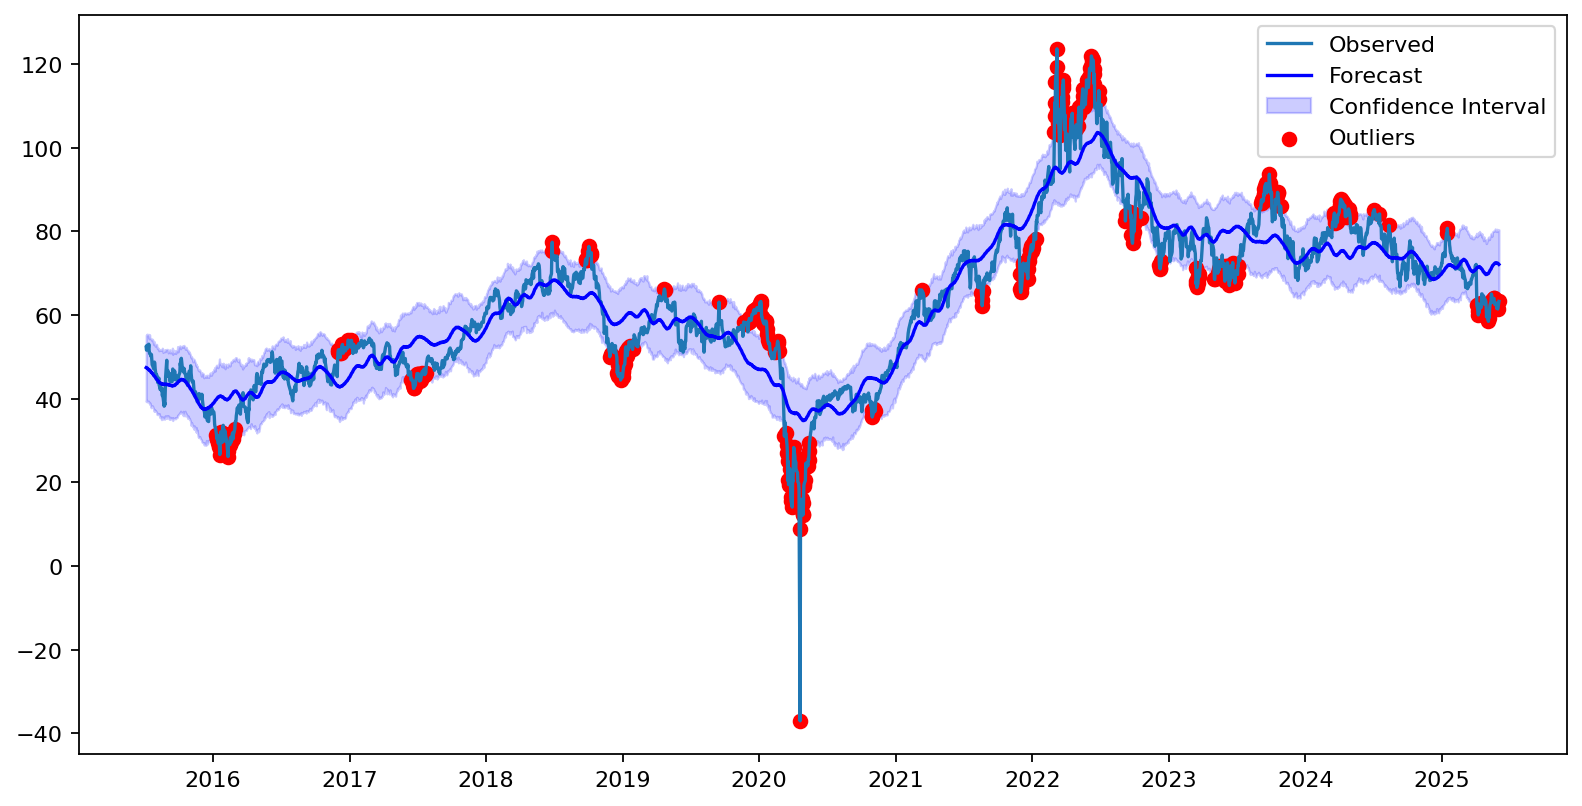

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6),dpi=160)
plt.plot(df_prophet['ds'], df_prophet['y'], label='Observed')
plt.plot(df_prophet['ds'], df_prophet['yhat'], 'b-', label='Forecast')
plt.fill_between(df_prophet['ds'], df_prophet['yhat_lower'], df_prophet['yhat_upper'], color='blue', alpha=0.2, label='Confidence Interval')

outliers = df_prophet[df_prophet['outlier']]
plt.scatter(outliers['ds'], outliers['y'], color='red', label='Outliers')

plt.legend()
plt.show()
